In [1]:
import os
import numpy as np
import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Dense, BatchNormalization, Activation, AveragePooling2D, Flatten
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.datasets import cifar100
from keras import backend as K
import pickle
import sklearn
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
%matplotlib inline
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
model_type = 'ResNet20v2'

In [3]:
#Loading data and embeddings
label_embeddings = pickle.load(open("Data/Embeddings/CIFAR/CIFAR_100_label_to_embedding_google_news.pk", "rb"))
embedding_len = len(label_embeddings[0])

save_dir_feat = os.path.join(os.getcwd(), 'saved_models/%s/extracted_feat/' % (model_type))
x_train = np.load(os.path.join(save_dir_feat, 'x_train_feat_cifar100_%s.npy' % (model_type)))
x_test = np.load(os.path.join(save_dir_feat, 'x_test_feat_cifar100_%s.npy' % (model_type)))
input_shape = x_train[0].shape

y_train = cifar100.load_data()[0][1]
y_test = cifar100.load_data()[1][1]

In [4]:
#Convert train/test labels to embeddings
y_train_embeddings = np.zeros((50000, embedding_len))
y_test_embeddings = np.zeros((10000, embedding_len))

for i in range(y_train.shape[0]):
    y_train_embeddings[i] = label_embeddings[int(y_train[i][0])]

for i in range(y_test.shape[0]):
    y_test_embeddings[i] = label_embeddings[int(y_test[i][0])]

label_embeddings_arr = np.zeros((100, embedding_len))
for i in range(100):
    label_embeddings_arr[i] = label_embeddings[i]

In [5]:
def build_model(input_shape=input_shape, embedding_len=embedding_len):
    inputs = Input(shape=input_shape)

    x = BatchNormalization()(inputs)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=2)(x)
    
    x = Flatten()(x)
    
    x = Dense(1024) (x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    
    x = Dense(512) (x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    
    x = Dense(embedding_len) (x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    
    outputs = Dense(embedding_len,
                    kernel_initializer='he_normal')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    return model

In [6]:
batch_size = 128
epochs = 100

In [7]:
model = build_model()
model.compile(loss='cosine_proximity', optimizer='adam', metrics=['mse'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 8, 8, 256)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 256)         1024      
_________________________________________________________________
activation_1 (Activation)    (None, 8, 8, 256)         0         
_________________________________________________________________
average_pooling2d_1 (Average (None, 4, 4, 256)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              4195328   
_________________________________________________________________
activation_2 (Activation)    (None, 1024)              0         
__________

In [8]:
save_dir = os.path.join(os.getcwd(), 'saved_models/%s/w2v_transfer/' % (model_type))
model_name = 'cifar100_%s_w2v_transfer_model.{epoch:03d}.h5' % (model_type)
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

In [9]:
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer]

In [10]:
model.fit(x_train, y_train_embeddings,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test_embeddings),
          shuffle=True,
          callbacks=callbacks,
          verbose=1
         )

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 7s 142us/step - loss: -0.6590 - mean_squared_error: 3.4811 - val_loss: -0.7019 - val_mean_squared_error: 3.2361

Epoch 00001: val_loss improved from inf to -0.70195, saving model to /home/tliu/Dev/CMU/10-715/10715_Project/saved_models/ResNet20v2/w2v_transfer/cifar100_ResNet20v2_w2v_transfer_model.001.h5
Epoch 2/100
50000/50000 [==============================] - 6s 112us/step - loss: -0.8313 - mean_squared_error: 3.5774 - val_loss: -0.7507 - val_mean_squared_error: 4.1881

Epoch 00002: val_loss improved from -0.70195 to -0.75070, saving model to /home/tliu/Dev/CMU/10-715/10715_Project/saved_models/ResNet20v2/w2v_transfer/cifar100_ResNet20v2_w2v_transfer_model.002.h5
Epoch 3/100
50000/50000 [==============================] - 6s 114us/step - loss: -0.8864 - mean_squared_error: 4.4274 - val_loss: -0.7598 - val_mean_squared_error: 6.0138

Epoch 00003: val_loss improved from -0.75070 

50000/50000 [==============================] - 6s 111us/step - loss: -0.9935 - mean_squared_error: 8.2189 - val_loss: -0.7806 - val_mean_squared_error: 7.2038

Epoch 00030: val_loss did not improve from -0.78063
Epoch 31/100
50000/50000 [==============================] - 6s 111us/step - loss: -0.9937 - mean_squared_error: 8.2168 - val_loss: -0.7805 - val_mean_squared_error: 7.3083

Epoch 00031: val_loss did not improve from -0.78063
Epoch 32/100
50000/50000 [==============================] - 6s 111us/step - loss: -0.9936 - mean_squared_error: 8.2120 - val_loss: -0.7805 - val_mean_squared_error: 7.3593

Epoch 00032: val_loss did not improve from -0.78063
Epoch 33/100
50000/50000 [==============================] - 5s 109us/step - loss: -0.9936 - mean_squared_error: 8.2088 - val_loss: -0.7804 - val_mean_squared_error: 7.3210

Epoch 00033: val_loss did not improve from -0.78063
Epoch 34/100
50000/50000 [==============================] - 5s 109us/step - loss: -0.9937 - mean_squared_error: 8

50000/50000 [==============================] - 6s 110us/step - loss: -0.9938 - mean_squared_error: 8.2045 - val_loss: -0.7806 - val_mean_squared_error: 7.3058

Epoch 00065: val_loss did not improve from -0.78080
Epoch 66/100
50000/50000 [==============================] - 6s 110us/step - loss: -0.9940 - mean_squared_error: 8.2064 - val_loss: -0.7805 - val_mean_squared_error: 7.2545

Epoch 00066: val_loss did not improve from -0.78080
Epoch 67/100
 4096/50000 [=>............................] - ETA: 4s - loss: -0.9937 - mean_squared_error: 8.2119

KeyboardInterrupt: 

In [15]:
#Top K Predictions
def pred_top_k(y_test_pred, label_embeddings_arr=label_embeddings_arr, k=5):
    sim_table = cosine_similarity(y_test_pred, label_embeddings_arr)
    top_k_guesses = np.argpartition(sim_table,range(99-k+1,100),axis=1)[:,99-k+1:]
    return sim_table, top_k_guesses

#Top k Accuracy
def calc_top_k_acc(top_k, y_test):
    correct = 0
    for i in range(y_test.shape[0]):
        if np.squeeze(y_test)[i] in top_k[i]:
            correct += 1
    return correct/float(y_test.shape[0])

def evaluate(model, x_test, y_test, label_embeddings_arr, k=5):
    y_test_pred = model.predict(x_test)
    sim_table, top_k_guesses = pred_top_k(y_test_pred, label_embeddings_arr, k=k)

    #Top prediction
    label_predictions = sim_table.argmax(axis=1)
    
    #Accuracy
    acc = np.sum((np.squeeze(y_test) == label_predictions)) / float(y_test.shape[0])
    top_k_acc = calc_top_k_acc(top_k_guesses, y_test)
    print("Accuracy: " + str(acc))
    print("Top " + str(k) + " Accuracy: " + str(top_k_acc))

In [16]:
best_model_filepath = os.path.join(save_dir, 'cifar100_%s_w2v_transfer_model.%03d.h5' % (model_type, 40))
best_model = load_model(best_model_filepath)

evaluate(best_model, x_test, y_test, label_embeddings_arr)

Accuracy: 0.6419
Top 5 Accuracy: 0.7704


In [17]:
evalute(best_model, x_train, y_train, label_embeddings_arr)

Accuracy: 0.99894
Top 5 Accuracy: 0.99958


Text(0.5, 1.0, 'Top K Accuracy')

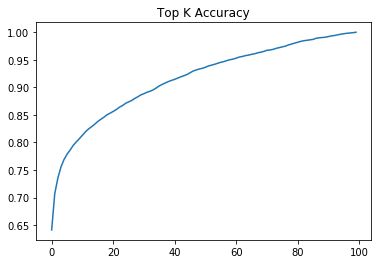

In [18]:
x = np.linspace(0,99,100) 
y = np.zeros(100)
y_test_pred = model.predict(x_test)

for i in range(100):
    k = i+1
    sim_table, top_k_guesses = pred_top_k(y_test_pred, k=k)
    y[i] = calc_top_k_acc(top_k_guesses, y_test)
    
plt.plot(x,y)
plt.title("Top K Accuracy")

In [ ]:
"""
model = build_model()
model.compile(loss='cosine_proximity', optimizer='adam', metrics=['mse'])
model.summary()

for i in range(epochs):
    print('Epoch: %d/%d' % (i+1, epochs))
    model.fit(x_train, y_train_embeddings,
              batch_size=batch_size,
              epochs=1,
              validation_data=(x_test, y_test_embeddings),
              shuffle=True,
              verbose=1
             )
    evalute(model, x_test, y_test, label_embeddings_arr)
    print('\n')
"""